# Dual Momentum Investing

In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from utils import historic_cdi

In [19]:
IBOV = yf.Ticker('^BVSP')
SP500 = yf.Ticker('^GSPC')

### IBOV

In [20]:
ibov_prices = IBOV.history(period='max', rounding=True)['Close']
ibov_prices.index = pd.to_datetime(ibov_prices.index).date

ibov_prices

1993-04-27        24.5
1993-04-28        24.3
1993-04-29        23.7
1993-04-30        24.1
1993-05-03        24.1
                ...   
2024-08-29    136041.0
2024-08-30    136004.0
2024-09-02    134981.0
2024-09-03    134353.0
2024-09-04    136111.0
Name: Close, Length: 7765, dtype: float64

In [21]:
# cálculo da cota

ibov = ibov_prices.div(ibov_prices.iloc[0])

ibov

1993-04-27       1.000000
1993-04-28       0.991837
1993-04-29       0.967347
1993-04-30       0.983673
1993-05-03       0.983673
                 ...     
2024-08-29    5552.693878
2024-08-30    5551.183673
2024-09-02    5509.428571
2024-09-03    5483.795918
2024-09-04    5555.551020
Name: Close, Length: 7765, dtype: float64

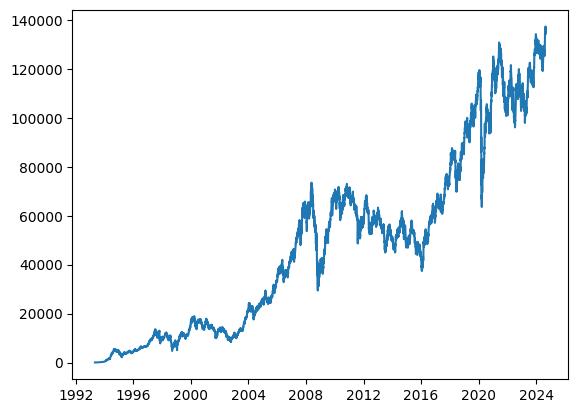

In [22]:
plt.plot(ibov_prices)
plt.show()

In [23]:
# variação diária do índice

ibov_prices_var = ibov_prices.pct_change()
ibov_prices_var = ibov_prices_var[1:len(ibov_prices_var.index)]

ibov_prices_var

1993-04-28   -0.008163
1993-04-29   -0.024691
1993-04-30    0.016878
1993-05-03    0.000000
1993-05-04    0.033195
                ...   
2024-08-29   -0.009487
2024-08-30   -0.000272
2024-09-02   -0.007522
2024-09-03   -0.004653
2024-09-04    0.013085
Name: Close, Length: 7764, dtype: float64

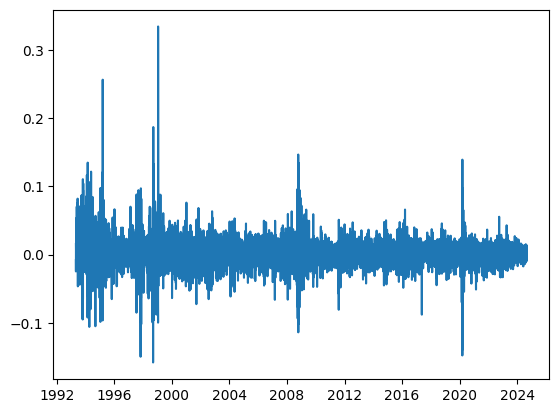

In [24]:
plt.plot(ibov_prices_var)
plt.show()

In [25]:
# retorno médio anualizado

ibov_avg_return = np.mean(ibov_prices_var) * 252

ibov_avg_return

np.float64(0.338303628275879)

In [26]:
# drawdown

ibov_cum_returns = (1 + ibov_prices_var).cumprod()
ibov_cum_max = ibov_cum_returns.cummax()

drawdown = (ibov_cum_returns - ibov_cum_max) / ibov_cum_max

drawdown

1993-04-28    0.000000
1993-04-29   -0.024691
1993-04-30   -0.008230
1993-05-03   -0.008230
1993-05-04    0.000000
                ...   
2024-08-29   -0.009487
2024-08-30   -0.009757
2024-09-02   -0.017205
2024-09-03   -0.021777
2024-09-04   -0.008977
Name: Close, Length: 7764, dtype: float64

In [27]:
round(min(drawdown), 2)

-0.65

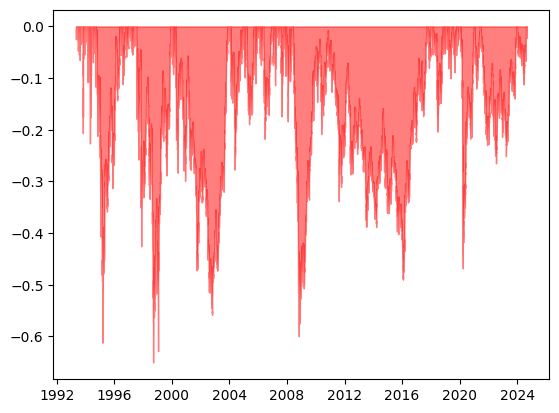

In [28]:
plt.fill_between(x=drawdown.index, y1=drawdown, color='red', alpha=0.5)
plt.show()

In [29]:
ibov_drawdown_shifts = (drawdown < 0).ne((drawdown < 0).shift()).cumsum()
ibov_drawdown_durations = (drawdown < 0).groupby(ibov_drawdown_shifts).size()

print(round(ibov_drawdown_durations.mean()))
print(ibov_drawdown_durations.max())

18
2304


### Absolute Momentum

In [30]:
start_date = datetime.strftime(ibov_prices.index.min(), format='%d/%m/%Y')
end_date = datetime.strftime(ibov_prices.index.max(), format='%d/%m/%Y')

In [31]:
cdi = historic_cdi(start=start_date, end=end_date)

cdi

1993-04-27       1.000000
1993-04-28       1.013950
1993-04-29       1.027888
1993-04-30       1.041693
1993-05-03       1.055360
                 ...     
2024-08-29    9735.420204
2024-08-30    9739.243304
2024-09-02    9743.067905
2024-09-03    9746.894008
2024-09-04    9750.721613
Name: valor, Length: 7871, dtype: float64

In [32]:
returns = pd.concat([ibov, cdi], keys=['IBOV', 'CDI'],  axis=1, join='inner')
returns.index = pd.to_datetime(returns.index)

returns.sort_index()

,IBOV,CDI
1993-04-27,1.000000,1.000000
1993-04-28,0.991837,1.013950
1993-04-29,0.967347,1.027888
1993-04-30,0.983673,1.041693
1993-05-03,0.983673,1.055360
...,...,...
2024-08-29,5552.693878,9735.420204
2024-08-30,5551.183673,9739.243304
2024-09-02,5509.428571,9743.067905
2024-09-03,5483.795918,9746.894008


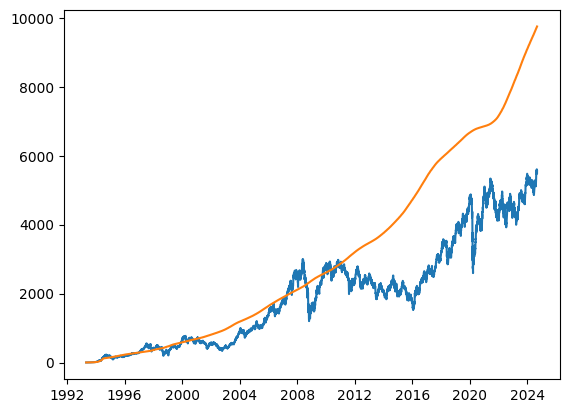

In [33]:
plt.plot(returns)
plt.show()

In [34]:
yearly_performance = returns.pct_change(periods=252).dropna()

yearly_performance

,IBOV,CDI
1994-05-04,63.236735,53.331335
1994-05-05,58.584362,53.527809
1994-05-06,62.725738,53.737763
1994-05-09,57.995851,53.966235
1994-05-10,63.232365,54.221954
...,...,...
2024-08-29,0.174418,0.113735
2024-08-30,0.161226,0.113626
2024-09-02,0.140004,0.113517
2024-09-03,0.143089,0.113408


In [35]:
yearly_performance['Excess Return'] = yearly_performance.apply(lambda x: 'IBOV' if x['IBOV'] > x['CDI'] else 'CDI', axis=1)

yearly_performance['Excess Return'].value_counts()

Excess Return
CDI     3812
IBOV    3698
Name: count, dtype: int64

In [36]:
first_trading_day = yearly_performance.index.to_series().groupby(yearly_performance.index.to_period('M')).apply(lambda x: x == x.min())

yearly_performance['Month Start'] = first_trading_day.values

yearly_performance

,IBOV,CDI,Excess Return,Month Start
1994-05-04,63.236735,53.331335,IBOV,True
1994-05-05,58.584362,53.527809,IBOV,False
1994-05-06,62.725738,53.737763,IBOV,False
1994-05-09,57.995851,53.966235,IBOV,False
1994-05-10,63.232365,54.221954,IBOV,False
...,...,...,...,...
2024-08-29,0.174418,0.113735,IBOV,False
2024-08-30,0.161226,0.113626,IBOV,False
2024-09-02,0.140004,0.113517,IBOV,True
2024-09-03,0.143089,0.113408,IBOV,False


In [37]:
yearly_performance['Investment'] = yearly_performance.loc[yearly_performance['Month Start'], 'Excess Return']
yearly_performance['Investment'] = yearly_performance['Investment'].ffill()

yearly_performance

,IBOV,CDI,Excess Return,Month Start,Investment
1994-05-04,63.236735,53.331335,IBOV,True,IBOV
1994-05-05,58.584362,53.527809,IBOV,False,IBOV
1994-05-06,62.725738,53.737763,IBOV,False,IBOV
1994-05-09,57.995851,53.966235,IBOV,False,IBOV
1994-05-10,63.232365,54.221954,IBOV,False,IBOV
...,...,...,...,...,...
2024-08-29,0.174418,0.113735,IBOV,False,CDI
2024-08-30,0.161226,0.113626,IBOV,False,CDI
2024-09-02,0.140004,0.113517,IBOV,True,IBOV
2024-09-03,0.143089,0.113408,IBOV,False,IBOV


In [38]:
returns_var = returns.pct_change().dropna()

absolute_momentum = returns_var.merge(yearly_performance[['Investment']], left_index=True, right_index=True,  how='right')

absolute_momentum['Absolute Momentum'] = absolute_momentum['IBOV']

absolute_momentum.loc[absolute_momentum['Investment'] != 'IBOV', 'Absolute Momentum'] = absolute_momentum['CDI']

absolute_momentum

,IBOV,CDI,Investment,Absolute Momentum
1994-05-04,-0.045256,0.017610,IBOV,-0.045256
1994-05-05,-0.079997,0.017617,IBOV,-0.079997
1994-05-06,0.043097,0.017650,IBOV,0.043097
1994-05-09,-0.058598,0.017660,IBOV,-0.058598
1994-05-10,0.088761,0.017833,IBOV,0.088761
...,...,...,...,...
2024-08-29,-0.009487,0.000393,CDI,0.000393
2024-08-30,-0.000272,0.000393,CDI,0.000393
2024-09-02,-0.007522,0.000393,IBOV,-0.007522
2024-09-03,-0.004653,0.000393,IBOV,-0.004653


In [39]:
absolute_momentum_eval = (1 + absolute_momentum.drop(columns=['Investment'])).cumprod()

absolute_momentum_eval

,IBOV,CDI,Absolute Momentum
1994-05-04,0.954744,1.017610,0.954744
1994-05-05,0.878367,1.035537,0.878367
1994-05-06,0.916222,1.053814,0.916222
1994-05-09,0.862533,1.072424,0.862533
1994-05-10,0.939092,1.091549,0.939092
...,...,...,...
2024-08-29,82.529119,182.341572,244.255410
2024-08-30,82.506673,182.413177,244.351329
2024-09-02,81.886071,182.484811,242.513358
2024-09-03,81.505096,182.556473,241.385063


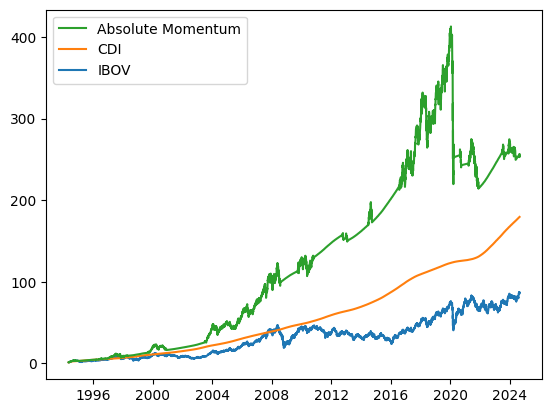

In [40]:
am_eval = absolute_momentum_eval.div(absolute_momentum_eval.iloc[0])

plt.plot(am_eval['IBOV'], label='IBOV')
plt.plot(am_eval['CDI'], label='CDI')
plt.plot(am_eval['Absolute Momentum'], label='Absolute Momentum')
plt.legend(loc='upper left', reverse=True)
plt.show()

In [41]:
am_daily_returns = am_eval.pct_change().dropna()

am_avg_return = am_eval.resample('YE').last().pct_change().mean()
am_avg_volatility = am_daily_returns.std() * (252 ** 0.5)

am_results = pd.concat([am_avg_return, am_avg_volatility], keys=['Avg Return', 'Avg Volatility'], axis=1)

am_results


,Avg Return,Avg Volatility
IBOV,0.179472,0.327463
CDI,0.153419,0.022106
Absolute Momentum,0.192614,0.208741


In [42]:
risk_free_rate = 0.1075

am_results['Sharpe Ratio'] = (am_results['Avg Return'] - risk_free_rate) / am_results['Avg Volatility']

am_results


,Avg Return,Avg Volatility,Sharpe Ratio
IBOV,0.179472,0.327463,0.219788
CDI,0.153419,0.022106,2.077245
Absolute Momentum,0.192614,0.208741,0.407748


### Relative Momentum

In [43]:
start_relative = '2004-01-01'

In [44]:
ibov_prices = IBOV.history(start=start_relative, end=datetime.now(), rounding=True)['Close']
ibov_prices.index = pd.to_datetime(ibov_prices.index).date
ibov_prices = (ibov_prices / ibov_prices.iloc[0])

ibov_prices

2004-01-02    1.000000
2004-01-05    1.048429
2004-01-06    1.050390
2004-01-07    1.038984
2004-01-08    1.056672
                ...   
2024-08-29    6.061083
2024-08-30    6.059434
2024-09-02    6.013856
2024-09-03    5.985877
2024-09-04    6.064201
Name: Close, Length: 5120, dtype: float64

In [45]:
sp500_prices = SP500.history(start=start_relative, end=datetime.now(), rounding=True)['Close']
sp500_prices.index = pd.to_datetime(sp500_prices.index).date
sp500_prices = (sp500_prices / sp500_prices.iloc[0])

sp500_prices

2004-01-02    1.000000
2004-01-05    1.012395
2004-01-06    1.013703
2004-01-07    1.016103
2004-01-08    1.021146
                ...   
2024-08-28    5.044908
2024-08-29    5.044710
2024-08-30    5.095626
2024-09-03    4.987848
2024-09-04    4.979855
Name: Close, Length: 5203, dtype: float64

In [46]:
relative_prices = pd.concat([ibov_prices, sp500_prices], keys=['IBOV', 'SP500'], join='inner', axis=1)

relative_prices

,IBOV,SP500
2004-01-02,1.000000,1.000000
2004-01-05,1.048429,1.012395
2004-01-06,1.050390,1.013703
2004-01-07,1.038984,1.016103
2004-01-08,1.056672,1.021146
...,...,...
2024-08-28,6.119136,5.044908
2024-08-29,6.061083,5.044710
2024-08-30,6.059434,5.095626
2024-09-03,5.985877,4.987848


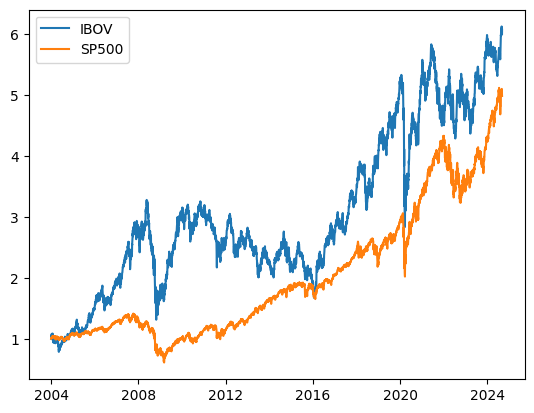

In [47]:
plt.plot(relative_prices)
plt.legend(relative_prices.columns)
plt.show()

In [48]:
relative_ytd_returns = relative_prices.pct_change(periods=252).dropna()
relative_ytd_returns.index = pd.to_datetime(relative_ytd_returns.index)

relative_ytd_returns


,IBOV,SP500
2005-01-18,0.073246,0.078937
2005-01-19,0.031404,0.055613
2005-01-20,0.001442,0.046046
2005-01-21,0.021355,0.036881
2005-01-24,0.020281,0.028120
...,...,...
2024-08-28,0.182257,0.260107
2024-08-29,0.176907,0.269651
2024-08-30,0.182829,0.292434
2024-09-03,0.164147,0.265285


In [49]:
relative_ftd = relative_ytd_returns.index.to_series().groupby(relative_ytd_returns.index.to_period('M')).apply(lambda x: x == x.min())

conditions = [
    relative_ftd.values & (relative_ytd_returns['IBOV'] > relative_ytd_returns['SP500']),
    relative_ftd.values & (relative_ytd_returns['IBOV'] <= relative_ytd_returns['SP500'])
]

relative_ytd_returns['Excess Return'] = np.select(conditions, ['IBOV', 'SP500'], default=None)
relative_ytd_returns['Investment'] = relative_ytd_returns['Excess Return'].ffill()

relative_ytd_returns

,IBOV,SP500,Excess Return,Investment
2005-01-18,0.073246,0.078937,SP500,SP500
2005-01-19,0.031404,0.055613,None,SP500
2005-01-20,0.001442,0.046046,None,SP500
2005-01-21,0.021355,0.036881,None,SP500
2005-01-24,0.020281,0.028120,None,SP500
...,...,...,...,...
2024-08-28,0.182257,0.260107,None,SP500
2024-08-29,0.176907,0.269651,None,SP500
2024-08-30,0.182829,0.292434,None,SP500
2024-09-03,0.164147,0.265285,SP500,SP500


In [50]:
relative_momentum = relative_prices.pct_change().dropna()
relative_momentum = relative_momentum.merge(relative_ytd_returns[['Investment']], left_index=True, right_index=True,  how='right')

relative_momentum['Relative Momentum'] = np.where(relative_momentum['Investment'] == 'IBOV', relative_momentum['IBOV'], relative_momentum['SP500'])
relative_momentum = relative_momentum.drop(columns=['Investment'])

relative_momentum

,IBOV,SP500,Relative Momentum
2005-01-18,-0.033502,0.009675,0.009675
2005-01-19,0.007555,-0.009490,-0.009490
2005-01-20,-0.027234,-0.007783,-0.007783
2005-01-21,0.008810,-0.006415,-0.006415
2005-01-24,0.015954,-0.003528,-0.003528
...,...,...,...
2024-08-28,0.004153,-0.005976,-0.005976
2024-08-29,-0.009487,-0.000039,-0.000039
2024-08-30,-0.000272,0.010093,0.010093
2024-09-03,-0.012139,-0.021151,-0.021151


In [51]:
relative_momentum_eval = (1 + relative_momentum).cumprod()
relative_momentum_eval = (relative_momentum_eval / relative_momentum_eval.iloc[0]) -1

relative_momentum_eval

,IBOV,SP500,Relative Momentum
2005-01-18,0.000000,0.000000,0.000000
2005-01-19,0.007555,-0.009490,-0.009490
2005-01-20,-0.019885,-0.017199,-0.017199
2005-01-21,-0.011250,-0.023504,-0.023504
2005-01-24,0.004525,-0.026949,-0.026949
...,...,...,...
2024-08-28,4.701524,3.675814,13.282560
2024-08-29,4.647432,3.675630,13.281998
2024-08-30,4.645896,3.722821,13.426148
2024-09-03,4.577359,3.622928,13.121018


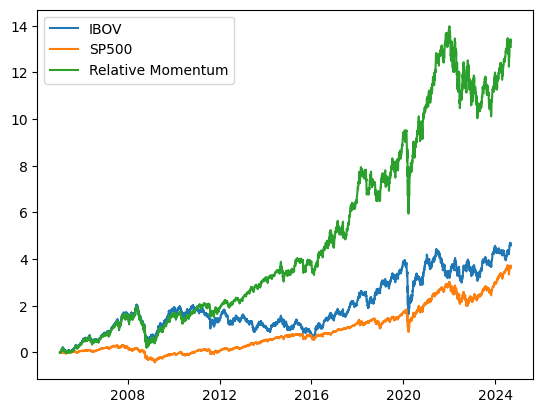

In [52]:
plt.plot(relative_momentum_eval)
plt.legend(relative_momentum_eval.columns)
plt.show()

In [53]:
rm_avg_return = relative_momentum_eval.resample('YE').last().pct_change().mean()
rm_avg_vol = relative_momentum.std() * (252 ** 0.5)

relative_momentum_results = pd.concat([rm_avg_return, rm_avg_vol], keys=['Avg Return', 'Avg Vol'], axis=1)

relative_momentum_results

,Avg Return,Avg Vol
IBOV,0.279084,0.268641
SP500,0.266768,0.194825
Relative Momentum,0.350470,0.239395


In [54]:
relative_momentum_results['Sharpe Ratio'] = (relative_momentum_results['Avg Return'] - risk_free_rate) / relative_momentum_results['Avg Vol']

relative_momentum_results

,Avg Return,Avg Vol,Sharpe Ratio
IBOV,0.279084,0.268641,0.638711
SP500,0.266768,0.194825,0.817492
Relative Momentum,0.350470,0.239395,1.014934


### Dual Momentum

In [56]:
dual_assets = [ibov_prices, sp500_prices, cdi]

dual_prices = pd.concat(dual_assets, keys=['IBOV', 'SP500', 'CDI'], join='inner', axis=1)
dual_prices = (dual_prices / dual_prices.iloc[0])

dual_prices

,IBOV,SP500,CDI
2004-01-02,1.000000,1.000000,1.000000
2004-01-05,1.048429,1.012395,1.000601
2004-01-06,1.050390,1.013703,1.001202
2004-01-07,1.038984,1.016103,1.001803
2004-01-08,1.056672,1.021146,1.002405
...,...,...,...
2024-08-28,6.119136,5.044908,8.205746
2024-08-29,6.061083,5.044710,8.208969
2024-08-30,6.059434,5.095626,8.212193
2024-09-03,5.985877,4.987848,8.218644


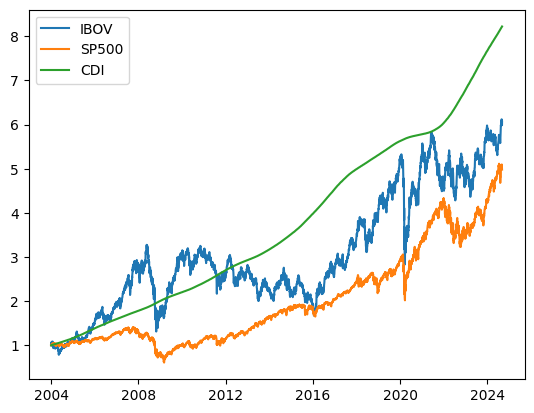

In [57]:
plt.plot(dual_prices)
plt.legend(dual_prices.columns)
plt.show()

In [67]:
dual_ytd_returns = dual_prices.pct_change(periods=252).dropna()
dual_ytd_returns.index = pd.to_datetime(dual_ytd_returns.index)

dual_ytd_returns

,IBOV,SP500,CDI
2005-01-18,0.073246,0.078937,0.170835
2005-01-19,0.031404,0.055613,0.170891
2005-01-20,0.001442,0.046046,0.170966
2005-01-21,0.021355,0.036881,0.171042
2005-01-24,0.020281,0.028120,0.171117
...,...,...,...
2024-08-28,0.182257,0.260107,0.117672
2024-08-29,0.176907,0.269651,0.117563
2024-08-30,0.182829,0.292434,0.117454
2024-09-03,0.164147,0.265285,0.117784


In [75]:
dual_ftd = dual_ytd_returns.index.to_series().groupby(dual_ytd_returns.index.to_period('M')).apply(lambda x: x == x.min())

conditions = [
    dual_ftd.values & (dual_ytd_returns['IBOV'] > dual_ytd_returns['CDI']) & (dual_ytd_returns['IBOV'] > dual_ytd_returns['SP500']),
    dual_ftd.values & (dual_ytd_returns['IBOV'] > dual_ytd_returns['CDI']) & (dual_ytd_returns['IBOV'] <= dual_ytd_returns['SP500']),
    dual_ftd.values & (dual_ytd_returns['IBOV'] <= dual_ytd_returns['CDI'])
]

cases = ['IBOV', 'SP500', 'CDI']

dual_ytd_returns['Excess Return'] = np.select(conditions, cases, default=None)
dual_ytd_returns['Investment'] = dual_ytd_returns['Excess Return'].ffill()

dual_ytd_returns

,IBOV,SP500,CDI,Excess Return,Investment
2005-01-18,0.073246,0.078937,0.170835,CDI,CDI
2005-01-19,0.031404,0.055613,0.170891,None,CDI
2005-01-20,0.001442,0.046046,0.170966,None,CDI
2005-01-21,0.021355,0.036881,0.171042,None,CDI
2005-01-24,0.020281,0.028120,0.171117,None,CDI
...,...,...,...,...,...
2024-08-28,0.182257,0.260107,0.117672,None,CDI
2024-08-29,0.176907,0.269651,0.117563,None,CDI
2024-08-30,0.182829,0.292434,0.117454,None,CDI
2024-09-03,0.164147,0.265285,0.117784,SP500,SP500


In [76]:
dual_ytd_returns['Investment'].value_counts(normalize=True)

Investment
CDI      0.504328
IBOV     0.420519
SP500    0.075153
Name: proportion, dtype: float64

In [78]:
dual_momentum = dual_prices.pct_change().dropna()
dual_momentum = dual_momentum.merge(dual_ytd_returns[['Investment']], left_index=True, right_index=True,  how='right')

dual_momentum['Dual Momentum'] = dual_momentum.apply(lambda x: x[x['Investment']], axis=1)
dual_momentum = dual_momentum.drop(columns=['Investment'])

dual_momentum

,IBOV,SP500,CDI,Dual Momentum
2005-01-18,-0.033502,0.009675,0.001297,0.001297
2005-01-19,0.007555,-0.009490,0.000649,0.000649
2005-01-20,-0.027234,-0.007783,0.000665,0.000665
2005-01-21,0.008810,-0.006415,0.000665,0.000665
2005-01-24,0.015954,-0.003528,0.000665,0.000665
...,...,...,...,...
2024-08-28,0.004153,-0.005976,0.000393,0.000393
2024-08-29,-0.009487,-0.000039,0.000393,0.000393
2024-08-30,-0.000272,0.010093,0.000393,0.000393
2024-09-03,-0.012139,-0.021151,0.000786,-0.021151


In [83]:
dual_momentum_eval = (1 + dual_momentum).cumprod()
dual_momentum_eval = (dual_momentum_eval / dual_momentum_eval.iloc[0]) -1

dual_momentum_eval

,IBOV,SP500,CDI,Dual Momentum
2005-01-18,0.000000,0.000000,0.000000,0.000000
2005-01-19,0.007555,-0.009490,0.000649,0.000649
2005-01-20,-0.019885,-0.017199,0.001314,0.001314
2005-01-21,-0.011250,-0.023504,0.001980,0.001980
2005-01-24,0.004525,-0.026949,0.002646,0.002646
...,...,...,...,...
2024-08-28,4.701524,3.675814,6.008458,12.669367
2024-08-29,4.647432,3.675630,6.011210,12.674735
2024-08-30,4.645896,3.722821,6.013964,12.680105
2024-09-03,4.577359,3.622928,6.019473,12.390755


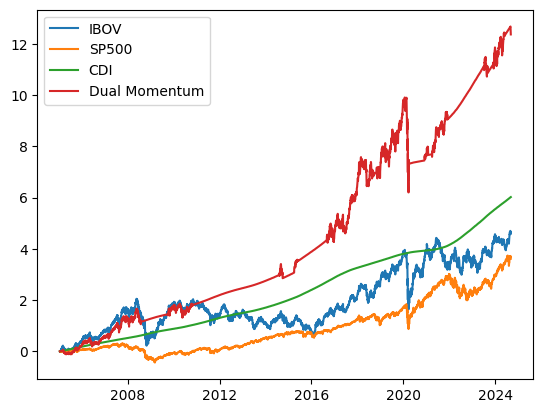

In [84]:
plt.plot(dual_momentum_eval)
plt.legend(dual_momentum_eval.columns)
plt.show()

In [86]:
dm_avg_return = dual_momentum_eval.resample('YE').last().pct_change().mean()
dm_avg_vol = dual_momentum.std() * (252 ** 0.5)

dual_momentum_results = pd.concat([dm_avg_return, dm_avg_vol], keys=['Avg Return', 'Avg Vol'], axis=1)

dual_momentum_results

,Avg Return,Avg Vol
IBOV,0.279084,0.268641
SP500,0.266768,0.194825
CDI,0.216607,0.002703
Dual Momentum,0.295123,0.164973


In [87]:
dual_momentum_results['Sharpe Ratio'] = (dual_momentum_results['Avg Return'] - risk_free_rate) / dual_momentum_results['Avg Vol']

dual_momentum_results

,Avg Return,Avg Vol,Sharpe Ratio
IBOV,0.279084,0.268641,0.638711
SP500,0.266768,0.194825,0.817492
CDI,0.216607,0.002703,40.367774
Dual Momentum,0.295123,0.164973,1.137296


### Naive Portfolio

In [101]:
strategies_price = [absolute_momentum_eval['Absolute Momentum'], relative_momentum_eval['Relative Momentum'], dual_momentum_eval['Dual Momentum']]
strategies_var = [absolute_momentum['Absolute Momentum'], relative_momentum['Relative Momentum'], dual_momentum['Dual Momentum']]

eval = pd.concat(strategies_price, join='inner', axis=1) + 1
eval = (eval / eval.iloc[0]) - 1

eval

,Absolute Momentum,Relative Momentum,Dual Momentum
2005-01-18,0.000000,0.000000,0.000000
2005-01-19,0.007392,-0.009490,0.000649
2005-01-20,-0.019455,-0.017199,0.001314
2005-01-21,-0.011007,-0.023504,0.001980
2005-01-24,0.004427,-0.026949,0.002646
...,...,...,...
2024-08-28,4.297791,13.282560,12.669367
2024-08-29,4.299863,13.281998,12.674735
2024-08-30,4.301936,13.426148,12.680105
2024-09-03,4.237836,13.121018,12.390755


In [104]:
eval_var = pd.concat(strategies_var, join='inner', axis=1)

eval_var

,Absolute Momentum,Relative Momentum,Dual Momentum
2005-01-18,-0.017377,0.009675,0.001297
2005-01-19,0.007555,-0.009490,0.000649
2005-01-20,-0.027234,-0.007783,0.000665
2005-01-21,0.008810,-0.006415,0.000665
2005-01-24,0.015954,-0.003528,0.000665
...,...,...,...
2024-08-28,0.000393,-0.005976,0.000393
2024-08-29,0.000393,-0.000039,0.000393
2024-08-30,0.000393,0.010093,0.000393
2024-09-03,-0.004653,-0.021151,-0.021151


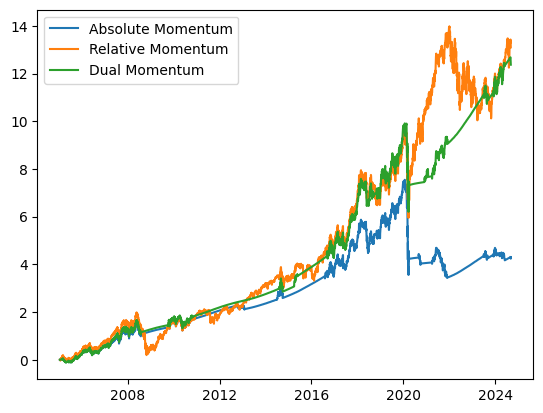

In [97]:
plt.plot(eval)
plt.legend(eval.columns)
plt.show()

In [105]:
avg_return = eval.resample('YE').last().pct_change().mean()
avg_vol = eval_var.std() * (252 ** 0.5)

total_results = pd.concat([avg_return, avg_vol], keys=['Avg Return', 'Avg Vol'], axis=1)

total_results

,Avg Return,Avg Vol
Absolute Momentum,0.238476,0.177450
Relative Momentum,0.350470,0.239395
Dual Momentum,0.295123,0.164973


In [106]:
total_results['Sharpe Ratio'] = (total_results['Avg Return'] - risk_free_rate) / total_results['Avg Vol']

total_results

,Avg Return,Avg Vol,Sharpe Ratio
Absolute Momentum,0.238476,0.177450,0.738098
Relative Momentum,0.350470,0.239395,1.014934
Dual Momentum,0.295123,0.164973,1.137296
